In [1]:
# Import our modularized components
from model_generator import load_model
from environment_generator import create_environment
from prompt_generator import llm_choose_action, parse_llm_response
from plot_results import plot_results

/opt/miniconda3/envs/UCL_OE/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/miniconda3/envs/UCL_OE/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/miniconda3/envs/UCL_OE/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <AEABF8CF-B1F8-3741-AC36-A5760858308E> /opt/miniconda3/envs/UCL_OE/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <E3D17B4A-4867-3D49-BC92-E04C28EE0F45> /opt/miniconda3/envs/UCL_OE/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
/opt/miniconda3/envs/UCL_OE/lib/python3.10/site-packages/transformers/loss/loss_for_object_detection.py:28: UserWarning: A

In [2]:
import sys

sys.path.append("../")

In [ ]:
import matplotlib.pyplot as plt

In [4]:
import utils
import gym, babyai_text
import torch
from transformers import PreTrainedTokenizer, AutoTokenizer
from trl import (
    PPOConfig,
    PPOTrainer,
    AutoModelForCausalLMWithValueHead,
    create_reference_model,
)
from typing import Dict, List, Any, Tuple
from rich.pretty import pprint

In [34]:
from prompt_generator import action_to_text, text_to_action

In [35]:
# from ppo_engine.sample_trajectory import sample_trajectory

In [44]:
model_id = "Qwen/Qwen2.5-1.5B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLMWithValueHead.from_pretrained(model_id)

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


In [45]:
# Load model
# google/flan-t5-small
# google/flan-t5-large
# Qwen/Qwen2.5-1.5B-Instruct

# generator = load_model("google/flan-t5-small")
# Create environment
env = create_environment()

Creating environment: BabyAI-MixedTrainLocal-v0...
Environment created successfully.



In [46]:
generation_kwargs = {
    "max_new_tokens": 20,
    "do_sample": True,
    "top_k": 10,
    "top_p": 0.95,
    "temperature": 0.8,
    "repetition_penalty": 1.2,
    "eos_token_id": tokenizer.eos_token_id,  # Ensure response stops at EOS
}

In [ ]:
import re


def sample_trajectory(
    env: gym.Env,
    trainer: PPOTrainer,
    tokenizer: PreTrainedTokenizer,
    generation_kwargs: Dict[str, Any],
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    max_steps: int = 128,
) -> Tuple[
    List[torch.Tensor], List[torch.Tensor], List[torch.Tensor], List[Dict[str, str]]
]:
    """
    Sample a trajectory from the environment using actions sampled from the current policy of the PPO trainer.
    Backfill the rewards for each observation-action pair according to the final reward received.

    Args:
        env (Env): The environment to sample from.
        trainer (PPOTrainer): The PPO trainer containing the current policy.
        tokenizer (PreTrainedTokenizer): The tokenizer used for encoding actions.
        generation_kwargs (Dict[str, Any]): Generation parameters for the policy.
        device (torch.device, optional): Device to use for computation. Defaults to GPU if available.
        max_steps (int, optional): Maximum number of steps to sample. Defaults to 128.

    Returns:
        Tuple[List[torch.Tensor], List[torch.Tensor], List[torch.Tensor], List[Dict[str, str]]]:
        A tuple containing:
            - query_tensors: List of tensors representing the queries.
            - response_tensors: List of tensors representing the responses.
            - rewards: List of tensors representing the rewards.
            - messages: List of dictionaries containing the messages exchanged.
    """
    query_tensors, response_tensors, rewards = [], [], []

    obs, info = env.reset()
    done = False

    messages = []

    mission = str(obs["mission"])
    # print('mission ', mission)
    system_prompt = utils.get_system_prompt()
    # print('system_prompt before replacing', system_prompt)
    # system_prompt = system_prompt.replace("{{goal}}", mission)
    system_prompt = system_prompt.format(goal=mission)
    # print('system_prompt ', system_prompt)
    messages.append({"role": "system", "content": system_prompt})

    text_obs = "\n".join(info["descriptions"])
    messages.append(
        {
            "role": "user",
            "content": text_obs
            + "\n\nRespond with only a single action from the list above.",
        }
    )

    # messages.append({"role": "user", "content": text_obs})

    for step in range(max_steps):
        # print("Step:", step)

        # print("Messages before tokenization:", messages)

        query_tensor = tokenizer.apply_chat_template(
            messages, return_tensors="pt", add_generation_prompt=False
        ).to(
            device
        )  # shape: (1, messages_length) removed , add_generation_prompt=True
        # query_tensor = query_tensor.squeeze(0) # shape: (messages_length,)
        query_tensors.append(query_tensor)

        # print("Query tensor shape:", query_tensor.shape)
        # print(f"Query tensor shape: {query_tensor.shape}")

        # TODO: should return_prompt be True or False? According to the quickstart it should be False, however according to the PPO docs it should be True
        response_tensor = trainer.generate(query_tensor, **generation_kwargs)[
            :, query_tensor.shape[-1] :
        ]  # shape: (1, new_tokens) removed [return_prompt=False]
        response_tensor = response_tensor.squeeze(0)  # shape: (new_tokens,)
        response_tensors.append(response_tensor)

        action_text = tokenizer.decode(response_tensor)
        messages.append({"role": "assistant", "content": action_text})
        print(action_text)

        match = re.search(r'"(.*?)"', action_text)

        if match:
            action_text = match.group(1)
            # print("Extracted text:", extracted_text)
        # else:
        #     print("No quoted text found.")
        if action_text not in utils.text_to_action:
            text_obs = (
                "You entered an invalid action, the valid actions are: "
                + str(list(utils.text_to_action.keys()))
                + "output only one word."
            )
            reward = -0.1
        else:
            action = utils.text_to_action[action_text]
            obs, reward, done, info = env.step(action)
            text_obs = "\n".join(info["descriptions"])

        reward = torch.tensor(reward).to(device)
        rewards.append(reward)
        messages.append({"role": "user", "content": text_obs})
        # print('done', done)
        if done:
            final_reward = reward
            for reward in rewards[:-1]:
                reward += final_reward  # add the final reward to all previous rewards
            break

    return query_tensors, response_tensors, rewards, messages

In [58]:
observations, actions, rewards, messages = sample_trajectory(
    env, model, tokenizer, generation_kwargs, max_steps=10
)
# pprint((observations, actions, rewards))
pprint(messages)

<|im_start|>system
go forward<|im_end|>
<|im_start|>assistent
forward<|im_end|>
<|im_start|>assistant
right<|im_end|>
<|im_start|>assistant
go forward<|im_end|>
<|im_start|>assistant
picked up<|im_end|>
<|im_start|>asivestasoon
dropped<|im_end|>
<|im_start|>assistant
.goBackwards<|im_end|>
<|im_start|>assistant
"go backward"<|im_end|>
<|im_start|>adtian
<|im_end|>
<|im_start|>assistant
<|im_end|>


[
│   {
│   │   'role': 'system',
│   │   'content': "You are an agent playing a simple navigation game. Your goal is to **open the yellow door**. The following are the possible actions you can take in the game, followed by a short description of each action:\n\nturn left: turn to the left,\nturn right: turn to the right,\ngo forward: take one step forward,\npick up: pick up the object below you,\ndrop: drop the object that you are holding,\ntoggle: manipulate the object in front of you.\n\nIn a moment I will present you an observation.\n\nTips:\n- Once the desired object you want to interact or pickup in front of you, you can use the 'toggle' action to interact with it.\n- It doesn't make sense to repeat the same action over and over if the observation doesn't change.\n\nPLAY!"
│   },
│   {
│   │   'role': 'user',
│   │   'content': 'You see a wall 1 step forward\nYou see a green ball 3 steps left\nYou see a green ball 1 step left\nYou see a red key 1 step right\n\nRespond with only a single action from the list above.'
│   },
│   {'role': 'assistant', 'content': '<|im_start|>system\ngo forward<|im_end|>'},
│   {
│   │   'role': 'user',
│   │   'content': "You entered an invalid action, the valid actions are: ['turn left', 'turn right', 'go forward', 'pick up', 'drop', 'toggle', 'done']output only one word."
│   },
│   {'role': 'assistant', 'content': '<|im_start|>assistent\nforward<|im_end|>'},
│   {
│   │   'role': 'user',
│   │   'content': "You entered an invalid action, the valid actions are: ['turn left', 'turn right', 'go forward', 'pick up', 'drop', 'toggle', 'done']output only one word."
│   },
│   {'role': 'assistant', 'content': '<|im_start|>assistant\nright<|im_end|>'},
│   {
│   │   'role': 'user',
│   │   'content': "You entered an invalid action, the valid actions are: ['turn left', 'turn right', 'go forward', 'pick up', 'drop', 'toggle', 'done']output only one word."
│   },
│   {'role': 'assistant', 'content': '<|im_start|>assistant\ngo forward<|im_end|>'},
│   {
│   │   'role': 'user',
│   │   'content': "You entered an invalid action, the valid actions are: ['turn left', 'turn right', 'go forward', 'pick up', 'drop', 'toggle', 'done']output only one word."
│   },
│   {'role': 'assistant', 'content': '<|im_start|>assistant\npicked up<|im_end|>'},
│   {
│   │   'role': 'user',
│   │   'content': "You entered an invalid action, the valid actions are: ['turn left', 'turn right', 'go forward', 'pick up', 'drop', 'toggle', 'done']output only one word."
│   },
│   {'role': 'assistant', 'content': '<|im_start|>asivestasoon\ndropped<|im_end|>'},
│   {
│   │   'role': 'user',
│   │   'content': "You entered an invalid action, the valid actions are: ['turn left', 'turn right', 'go forward', 'pick up', 'drop', 'toggle', 'done']output only one word."
│   },
│   {'role': 'assistant', 'content': '<|im_start|>assistant\n.goBackwards<|im_end|>'},
│   {
│   │   'role': 'user',
│   │   'content': "You entered an invalid action, the valid actions are: ['turn left', 'turn right', 'go forward', 'pick up', 'drop', 'toggle', 'done']output only one word."
│   },
│   {'role': 'assistant', 'content': '<|im_start|>assistant\n"go backward"<|im_end|>'},
│   {
│   │   'role': 'user',
│   │   'content': "You entered an invalid action, the valid actions are: ['turn left', 'turn right', 'go forward', 'pick up', 'drop', 'toggle', 'done']output only one word."
│   },
│   {'role': 'assistant', 'content': '<|im_start|>adtian\n<|im_end|>'},
│   {
│   │   'role': 'user',
│   │   'content': "You entered an invalid action, the valid actions are: ['turn left', 'turn right', 'go forward', 'pick up', 'drop', 'toggle', 'done']output only one word."
│   },
│   {'role': 'assistant', 'content': '<|im_start|>assistant\n<|im_end|>'},
│   {
│   │   'role': 'user',
│   │   'content': "You entered an invalid action, the valid actions are: ['turn left', 'turn right', 'go forward', 'pick up', 'drop', 'toggle', 'done']output only one word."
│   }
]

In [ ]:
import re


def format_chat_text(messages):
    """
    Convert structured chat messages into a human-readable conversation format.

    Args:
        messages (List[Dict[str, str]]): A list of message dictionaries containing 'role' and 'content'.

    Returns:
        str: Formatted conversation text.
    """
    role_labels = {
        "system": "🔹 System:",
        "user": "🧑 User:",
        "assistant": "🤖 Assistant:",
    }

    formatted_text = ""

    for msg in messages:
        role = msg.get("role", "").strip()
        content = msg.get("content", "").strip()

        # Remove special formatting tokens
        content = content.replace("<|im_start|>", "").replace("<|im_end|>", "").strip()

        # Skip empty or meaningless assistant messages
        if role == "assistant" and not content:
            continue

        # Add role labels if recognized
        role_label = role_labels.get(role, role.capitalize())
        formatted_text += f"\n{role_label}\n{content}\n"

    # Trim leading/trailing spaces and return
    return formatted_text.strip()

In [33]:
tokenizer.decode(observations[1].squeeze(0))

"<|im_start|>system\nYou are an agent playing a simple navigation game. Your goal is to **pick up the purple box**. The following are the possible actions you can take in the game, followed by a short description of each action:\n\nturn left: turn to the left,\nturn right: turn to the right,\ngo forward: take one step forward,\npick up: pick up the object below you,\ndrop: drop the object that you are holding,\ntoggle: manipulate the object in front of you.\n\nIn a moment I will present you an observation.\n\nTips:\n- Once the desired object you want to interact or pickup in front of you, you can use the 'toggle' action to interact with it.\n- It doesn't make sense to repeat the same action over and over if the observation doesn't change.\n\nPLAY!<|im_end|>\n<|im_start|>user\nYou see a wall 1 step forward\nYou see a wall 3 steps right\n\nRespond with only a single action from the list above.<|im_end|>\n<|im_start|>assistant\n<|im_start|>assistant\nI'm ready for your next move after thi

In [31]:
print(format_chat_text(tokenizer.decode(observations[1].squeeze(0))))

TypeError: argument 'ids': 'list' object cannot be interpreted as an integer

In [ ]:
# Track results
episode_rewards = []
episode_steps = []


def run_episode(env, generator):
    """
    Runs one BabyAI episode using the LLM to select actions.
    Returns total reward and number of steps.
    """

    obs, info = env.reset()
    done = False
    step = 0
    total_reward = 0

    # Get mission text
    mission = obs.get("mission", "No mission provided")
    print("Mission:\n", mission, "\n")

    while not done:
        step += 1

        # Extract descriptions
        descriptions = info.get("descriptions", [])

        # Choose action via LLM
        action_id = llm_choose_action(generator, mission, descriptions)
        action_str = action_to_text.get(action_id, f"Unknown({action_id})")

        # Take step in environment
        obs, reward, done, info = env.step(action_id)

        # Track reward
        total_reward += reward

        # Log step
        print(
            f"Step {step}: Action = {action_str} (ID={action_id}), Reward={reward}, Done={done}\n"
        )

    print(f"Episode finished in {step} steps with total reward {total_reward}.\n")
    return total_reward, step

: 

: 

: 

In [ ]:
# Run multiple episodes and collect data
num_episodes = 20  # Adjust as needed
for i in range(num_episodes):
    print(f"=== Starting Episode {i+1} ===")
    reward, steps = run_episode(env, generator)
    episode_rewards.append(reward)
    episode_steps.append(steps)
    print("=" * 50)

# Close environment
env.close()

=== Starting Episode 1 ===
Mission:
 put a grey ball next to the grey box 

LLM Prompt:
 Mission: put a grey ball next to the grey box

Observations:
You see a wall 5 steps forward
You see a green ball 2 steps left and 4 steps forward
You see a purple key 2 steps left and 1 step forward
You see a purple key 2 steps left
You see a grey ball 1 step right and 4 steps forward
You see a grey ball 1 step right and 3 steps forward
You see a blue ball 1 step right and 1 step forward
You see a grey box 2 steps right and 1 step forward
You see a yellow key 3 steps right and 1 step forward

Available actions:
0: turn left
1: turn right
2: go forward
3: pick up
4: drop
5: toggle
6: done

Think step by step about what might be the best action to take given the mission and observations.
After your reasoning, on a new line, write 'Final action:' followed by one of the available actions exactly as written above.

LLM Response:
 4
Chose action by numeric ID: 4 -> drop
Step 1: Action = drop (ID=4), Rewa

: 

: 

: 

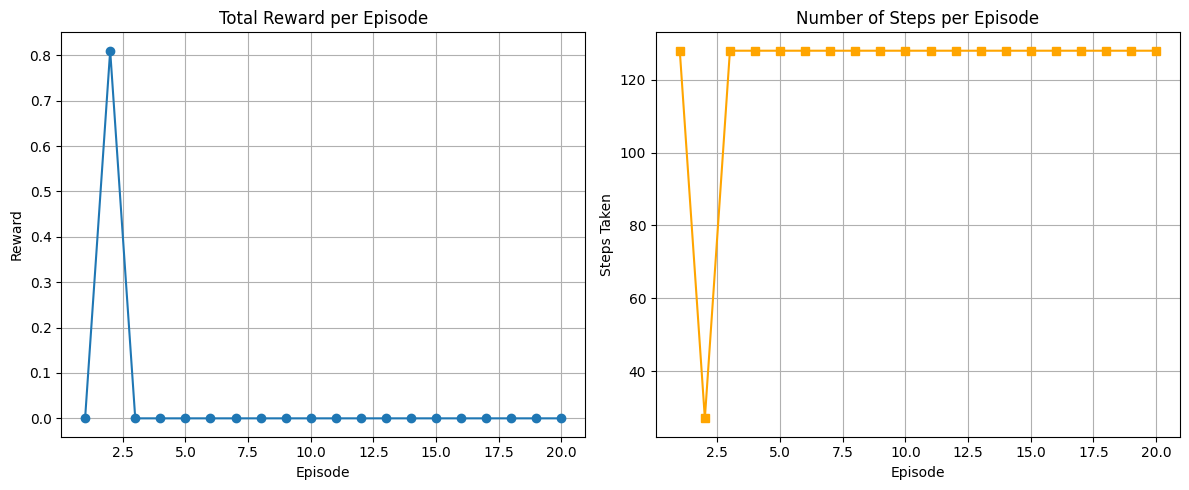

: 

: 

: 

In [ ]:
# Generate performance plots
plot_results(episode_rewards, episode_steps)

: 

: 

: 